# Pre-processing and RNA velocity analysis of single-cell RNA-seq data with kallisto|bustools.

In this notebook, we will perform pre-processing and RNA velocity analysis of human week 10 fetal forebrain dataset ([SRR6470906](https://www.ncbi.nlm.nih.gov/sra/?term=SRR6470906) and [SRR6470907](https://www.ncbi.nlm.nih.gov/sra/?term=SRR6470907)) from [La Manno et al., 2018](https://doi.org/10.1038/s41586-018-0414-6) using the **kallisto | bustools** workflow, implemented with a wrapper called `kb`. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

__Note:__ The human RNA velocity index used in this tutorial requires at least 16GB of RAM, which means you need to be on a GPU runtime on Google Colab. To change your runtime to a GPU instance, go to `Runtime` > `Change runtime type` > select `GPU` from the `Hardware accelerator` dropdown.

Downloading and processing the data takes a while (> 2 hours). If you would like to use checkpoint files, which reduce this to ~30 minutes, follow these steps:
1. Skip the *Download the data* step.
2. Follow through the pre-processing steps. Stop before *Generate RNA velocity count matrices*.
3. Uncomment the commented commands in the cells that run `kb count`.
4. Continue through the tutorial.

In [ ]:
!date

Wed Aug 25 09:40:44 UTC 2021


## Pre-processing

### Download the data

__Note:__ We use the `-O` option for `wget` to rename the files to easily identify them.

In [ ]:
%%time
!wget https://caltech.box.com/shared/static/8w79k2ydhqigkb4cfhosc6k32zycizdq.txt -O checksums.txt
# SRR6470907
!wget https://caltech.box.com/shared/static/nvzqphhklk1yx938l6omursw7sr68y43.gz -O SRR6470906_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/63fh2xa5t82x7s74rqa0e2u2ur59y5ox.gz -O SRR6470906_S1_L001_R2_001.fastq.gz
!wget https://caltech.box.com/shared/static/zqi3durukillaw1pbns1kd1lowyfg5qk.gz -O SRR6470906_S1_L002_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/i56qojfz41ns1kw9z86sla0vawsch96t.gz -O SRR6470906_S1_L002_R2_001.fastq.gz
# SRR6470907
!wget https://caltech.box.com/shared/static/vrditbbk38tw3f61fwpg504vcc5x09ci.gz -O SRR6470907_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/8ud3otwztjeqlmjctbu1fw7hg3k56ejr.gz -O SRR6470907_S1_L001_R2_001.fastq.gz
!wget https://caltech.box.com/shared/static/ln14jjd4tz3hvgxf8zj2kmokof7f1nrf.gz -O SRR6470907_S1_L002_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/o5bwf9u2g7egi02by3e3hbvov8fgwbb3.gz -O SRR6470907_S1_L002_R2_001.fastq.gz

Then, we verify the integrity of the files we downloaded to make sure they were not corrupted during the download.

In [ ]:
!md5sum -c checksums.txt --ignore-missing

SRR6470906_S1_L001_R1_001.fastq.gz: OK
SRR6470906_S1_L001_R2_001.fastq.gz: OK
SRR6470906_S1_L002_R1_001.fastq.gz: OK
SRR6470906_S1_L002_R2_001.fastq.gz: OK
SRR6470907_S1_L001_R1_001.fastq.gz: OK
SRR6470907_S1_L001_R2_001.fastq.gz: OK
SRR6470907_S1_L002_R1_001.fastq.gz: FAILED
SRR6470907_S1_L002_R2_001.fastq.gz: FAILED
md5sum: WARNING: 2 computed checksums did NOT match


### Install `kb`

Install `kb` for running the kallisto|bustools workflow.

In [2]:
!pip install kb-python==0.24.1

     |████████████████████████████████| 35.4 MB 82 kB/s 
     |████████████████████████████████| 41 kB 103 kB/s 
     |████████████████████████████████| 127 kB 63.7 MB/s 
     |████████████████████████████████| 109 kB 60.6 MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-py3-none-any.whl size=47905 sha256=d204001ebb5e8ba135b191d9b292caaed6bd8676e386058e0de25c55a0f11a1e
  Stored in directory: /root/.cache/pip/wheels/aa/84/e5/38fa2e3b59faa40b027a12a0c2de64cd787a1cbf05725fb021
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.13-py3-none-any.whl size=24089 sha256=c7169e5db2bde56d26d6e0067ea0929c0230331c600726df0f633d30ec0e2daa
  Stored in directory: /root/.cache/pip/wheels/58/cb/92/7fa39c89e5deef32c76ce70ddedf77b56660e0fb4398c8d300
Successfully built loompy numpy-groupies


### Download a pre-built human RNA velocity index

`kb` provides a pre-built human RNA velocity index, which is suitable for 10x data only. See this notebook to understand how the index was generated: https://github.com/linnarsson-lab/loompy/blob/master/notebooks/build_index.ipynb Because this is a velocity index, we need to provide the `-c1` and `-c2` options when downloading to indicate what we want to name our transcripts-to-capture lists. These lists contain transcript IDs that correspond to spliced and unspliced variants of genes, the sequences of which were used to generate the `index.idx` file.

__Note:__ See [this notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_velocity_index.ipynb) for a tutorial on how to build custom transcriptome or RNA velocity indices.

In [4]:
%%time
!kb ref -d linnarsson -i index.idx -g t2g.txt -c1 spliced_t2c.txt -c2 unspliced_t2c.txt

[2021-08-26 01:35:42,093]    INFO Downloading files for linnarsson from https://caltech.box.com/shared/static/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz to tmp/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz
[2021-08-26 01:39:04,759]    INFO Extracting files from tmp/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz
CPU times: user 1.91 s, sys: 308 ms, total: 2.21 s
Wall time: 5min 9s


### Generate RNA velocity count matrices

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice we are providing the index and transcript-to-gene mapping we downloaded in the previous step to the `-i` and `-g` arguments respectively, as well as the transcripts-to-capture lists to the `-c1` and `-c2` arguments. Also, these reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, hence the `-x 10xv2` argument. To view other supported technologies, run `kb --list`.

The `--filter` flag is used to filter out barcodes with low UMI counts. This will generate two matrices, one in the `counts_unfiltered` directory and another in the `counts_filtered` directory.

__Note:__ If you would like a Loom file instead, replace the `--h5ad` flag with `--loom`. If you want to use the raw matrix output by `kb` instead of their H5AD or Loom converted files, omit these flags.

#### SRR6470906

In [1]:
%%time
# Uncomment the following two lines if you want to use checkpoint files
!wget https://caltech.box.com/shared/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz -O SRR64070906.tar.gz
!tar -xzvf SRR64070906.tar.gz


--2021-08-26 01:28:17--  https://caltech.box.com/shared/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz [following]
--2021-08-26 01:28:18--  https://caltech.box.com/public/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz [following]
--2021-08-26 01:28:18--  https://caltech.app.box.com/public/static/wt1xo5ro9v7qo4fi4dl52kbbcg0omlve.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.29.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [5]:
# ! rm *tar.gz
! kb count --h5ad -i index.idx -g t2g.txt -x 10xv2 -o SRR6470906 \
-c1 spliced_t2c.txt -c2 unspliced_t2c.txt --lamanno -t 2 \
SRR6470906_S1_L001_R1_001.fastq.gz \
SRR6470906_S1_L001_R2_001.fastq.gz \
SRR6470906_S1_L002_R1_001.fastq.gz \
SRR6470906_S1_L002_R2_001.fastq.gz

[2021-08-26 01:40:51,728]    INFO Skipping kallisto bus because output files already exist. Use the --overwrite flag to overwrite.
[2021-08-26 01:40:51,729]    INFO Sorting BUS file SRR6470906/output.bus to tmp/output.s.bus
[2021-08-26 01:44:23,914]    INFO Whitelist not provided
[2021-08-26 01:44:23,914]    INFO Copying pre-packaged 10XV2 whitelist to SRR6470906
[2021-08-26 01:44:28,244]    INFO Inspecting BUS file tmp/output.s.bus
[2021-08-26 01:45:08,585]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist SRR6470906/10xv2_whitelist.txt
[2021-08-26 01:45:48,232]    INFO Sorting BUS file tmp/output.s.c.bus to SRR6470906/output.unfiltered.bus
[2021-08-26 01:47:12,525]    INFO Capturing records from BUS file SRR6470906/output.unfiltered.bus to tmp/spliced.bus with capture list spliced_t2c.txt
[2021-08-26 01:48:10,084]    INFO Sorting BUS file SRR6470906/output.unfiltered.bus to SRR6470906/spliced.s.bus
[2021-08-26 01:49:23,227]    INFO Generating cou

#### SRR6470907

In [6]:
%%time
# Uncomment the following two lines if you want to use checkpoint files
!wget https://caltech.box.com/shared/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz -O SRR64070907.tar.gz
!tar -xzvf SRR64070907.tar.gz


--2021-08-26 01:54:34--  https://caltech.box.com/shared/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.29.197
Connecting to caltech.box.com (caltech.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz [following]
--2021-08-26 01:54:34--  https://caltech.box.com/public/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz [following]
--2021-08-26 01:54:35--  https://caltech.app.box.com/public/static/bulmquvaflr18v0nqb8c3ataf9di55r8.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.29.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [7]:
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv2 -o SRR6470907 \
-c1 spliced_t2c.txt -c2 unspliced_t2c.txt --lamanno -t 2 \
SRR6470907_S1_L001_R1_001.fastq.gz \
SRR6470907_S1_L001_R2_001.fastq.gz \
SRR6470907_S1_L002_R1_001.fastq.gz \
SRR6470907_S1_L002_R2_001.fastq.gz

[2021-08-26 01:57:10,305]    INFO Skipping kallisto bus because output files already exist. Use the --overwrite flag to overwrite.
[2021-08-26 01:57:10,305]    INFO Sorting BUS file SRR6470907/output.bus to tmp/output.s.bus
[2021-08-26 01:59:27,500]    INFO Whitelist not provided
[2021-08-26 01:59:27,501]    INFO Copying pre-packaged 10XV2 whitelist to SRR6470907
[2021-08-26 01:59:35,510]    INFO Inspecting BUS file tmp/output.s.bus
[2021-08-26 02:00:24,544]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist SRR6470907/10xv2_whitelist.txt
[2021-08-26 02:01:18,647]    INFO Sorting BUS file tmp/output.s.c.bus to SRR6470907/output.unfiltered.bus
[2021-08-26 02:03:15,535]    INFO Capturing records from BUS file SRR6470907/output.unfiltered.bus to tmp/spliced.bus with capture list spliced_t2c.txt
[2021-08-26 02:04:21,001]    INFO Sorting BUS file SRR6470907/output.unfiltered.bus to SRR6470907/spliced.s.bus
[2021-08-26 02:06:30,749]    INFO Generating cou

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by `kb count` into Python and cluster the cells with Louvain.

### Install packages

Google Colab does not come with `scanpy`, `python-igraph`, or `louvain` (but comes with `matplotlib`, `numpy`, `pandas`, and `scipy`).

In [8]:
!pip install scanpy loompy scvelo anndata velocyto python-igraph louvain

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
     |████████████████████████████████| 177 kB 64.6 MB/s 
     |████████████████████████████████| 198 kB 43.6 MB/s 
     |████████████████████████████████| 3.2 MB 20.9 MB/s 
     |████████████████████████████████| 2.1 MB 45.7 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 1.1 MB 60.5 MB/s 
     |████████████████████████████████| 69 kB 6.3 MB/s 
     |████████████████████████████████| 9.9 MB 11.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67949 sha256=eec3cba9e4262e3aaac877a97673aeb039f5ded02c87c3a3ae9568de83016d4d
  Stored in directory: /root/.cache/pip/wheels/14/9a/ed/66159a5e13d3b6341b6542cf4f1faf478834753bed5ecaef8d
  Created wheel for velocyto: filename=velocyto-0.17.17-cp37-cp37m-linux_x86_64.whl size=363609 sha256=4bd96d520d23d51d63294742979f1923713ab24c66b9192f96abcc37c6e

We also install an `R` package called `princurve`, which is used to fit a principal curve.

__Note:__ Google Colab does not official support `R` as of writing this tutorial, so this process may change with the official release. At the moment, we need to "hack" Google Colab to install `R` dependencies.

In [9]:
!Rscript -e "install.packages('princurve')"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/princurve_2.1.6.tar.gz'
Content type 'application/x-gzip' length 52656 bytes (51 KB)
downloaded 51 KB

* installing *source* package ‘princurve’ ...
** package ‘princurve’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/lib/R/site-library/Rcpp/include'    -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-5XUBcI/r-base-4.1.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/lib/R/site-library/Rcpp/include'    -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-5XUBcI/r-base-4.1.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c project_to_curve.cpp -o project_to_curve.o
g++ -std=gnu++14 

### Import packages

In [10]:
import anndata
import igraph
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rpy2.robjects as robj
import scanpy as sc
import scipy
import scipy.optimize
import scvelo as scv
import sklearn
import velocyto as vcy

from collections import Counter
from IPython.core.display import display, HTML
from numpy_groupies import aggregate, aggregate_np
from rpy2.robjects.packages import importr
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Import H5AD-formatted Anndata matrices

In [36]:
adata_06 = anndata.read('SRR6470906/counts_unfiltered/adata.h5ad')
adata_07 = anndata.read('SRR6470907/counts_unfiltered/adata.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
# ! rm -r SRR*
# ! rm index.idx
# ! rm spliced*
# ! rm t2g.txt
# ! rm unspliced*

rm: cannot remove 'index.idx': No such file or directory
rm: cannot remove 'spliced*': No such file or directory
rm: cannot remove 't2g.txt': No such file or directory
rm: cannot remove 'unspliced*': No such file or directory


In [37]:
adata_06.var_names_make_unique()
adata_07.var_names_make_unique()
adata_06

AnnData object with n_obs × n_vars = 404585 × 58367
    layers: 'spliced', 'unspliced'

### Combine both matrices into a single Anndata object

In [38]:
# Before we do, we need to make sure we can trace each row back to its
# original anndata object.
adata_06.obs['run'] = '06'
adata_07.obs['run'] = '07'
adata_06.obs['bcs'] = adata_06.obs.index
adata_07.obs['bcs'] = adata_07.obs.index
adata_06.obs.index = adata_06.obs['bcs'] + '.' + adata_06.obs['run']
adata_07.obs.index = adata_07.obs['bcs'] + '.' + adata_07.obs['run']

adata = adata_06.concatenate(adata_07, batch_key='batch')

Let's remove the `-0` prefixes from the `obs` index.

In [39]:
adata.obs.head()

,run,bcs,batch
AAACCTGAGAAACCAT.06-0,06,AAACCTGAGAAACCAT,0
AAACCTGAGAAACCGC.06-0,06,AAACCTGAGAAACCGC,0
AAACCTGAGAAAGTGG.06-0,06,AAACCTGAGAAAGTGG,0
AAACCTGAGAACAACT.06-0,06,AAACCTGAGAACAACT,0
AAACCTGAGAACAATC.06-0,06,AAACCTGAGAACAATC,0


In [40]:
adata.obs.index = adata.obs.index.str.split('-').str[0]
adata.obs.head()

,run,bcs,batch
AAACCTGAGAAACCAT.06,06,AAACCTGAGAAACCAT,0
AAACCTGAGAAACCGC.06,06,AAACCTGAGAAACCGC,0
AAACCTGAGAAAGTGG.06,06,AAACCTGAGAAAGTGG,0
AAACCTGAGAACAACT.06,06,AAACCTGAGAACAACT,0
AAACCTGAGAACAATC.06,06,AAACCTGAGAACAATC,0


Let's also remove the gene versions from the `var` index.

In [41]:
adata.var.head()

""
gene_id
ENSG00000277400
ENSG00000274847
ENSG00000276256
ENSG00000278198
ENSG00000273496


In [42]:
adata.var.index = adata.var.index.str.split('.').str[0]
adata.var.head()

""
gene_id
ENSG00000277400
ENSG00000274847
ENSG00000276256
ENSG00000278198
ENSG00000273496


In [43]:
adata.obs.index

Index(['AAACCTGAGAAACCAT.06', 'AAACCTGAGAAACCGC.06', 'AAACCTGAGAAAGTGG.06',
       'AAACCTGAGAACAACT.06', 'AAACCTGAGAACAATC.06', 'AAACCTGAGAACTCGG.06',
       'AAACCTGAGAAGAAGC.06', 'AAACCTGAGAAGATTC.06', 'AAACCTGAGAAGGACA.06',
       'AAACCTGAGAAGGCCT.06',
       ...
       'TTTGTCATCTTGCAAG.07', 'TTTGTCATCTTGCCGT.07', 'TTTGTCATCTTGGGTA.07',
       'TTTGTCATCTTGTATC.07', 'TTTGTCATCTTGTCAT.07', 'TTTGTCATCTTGTTTG.07',
       'TTTGTCATCTTTACAC.07', 'TTTGTCATCTTTACGT.07', 'TTTGTCATCTTTAGTC.07',
       'TTTGTCATCTTTCCTC.07'],
      dtype='object', length=807273)

### Select the right barcodes and genes

Our Anndata matrix so far contains all genes and barcodes. Here, we will take the genes and barcodes present in our matrix and the matrix published with this dataset.

#### Download the matrix

In [24]:
them = scv.read('data/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()

  0%|          | 0.00/29.2M [00:00<?, ?B/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [35]:
them.obs.index

Index(['AACCATGGTAATCACC.07', 'AACCATGCATACTACG.07', 'AAACCTGGTAAAGGAG.07',
       'AAAGTAGCAAAGTCAA.07', 'AAAGCAACAAACGCGA.07', 'AAACCTGCACGGTTTA.07',
       'AAAGTAGCACGCTTTC.07', 'AAACCTGTCCTAGTGA.07', 'AAAGCAACACACAGAG.07',
       'AAACGGGTCTGCGTAA.07',
       ...
       'TTGTAGGAGGATATAC.06', 'TTTCCTCCAGATGGGT.06', 'TTTACTGTCTTTACAC.06',
       'TTTGGTTAGATGGCGT.06', 'TTTATGCAGCTCAACT.06', 'TTTATGCGTTGCGCAC.06',
       'TTTGCGCGTTCCGTCT.06', 'TTTGGTTGTACCCAAT.06', 'TTTCCTCCAGTCCTTC.06',
       'TTTGCGCCACAGATTC.06'],
      dtype='object', name='run', length=1720)

Clean it up so that we can compare it to ours

In [25]:
them.obs["bcs"] = them.obs.index.str.slice(11,-1)
them.obs["bid"] = them.obs.index.str.slice(8,10)
them.obs["run"] = them.obs.bid.map(lambda x: "06" if x=="29" else "07")
them.obs.index = them.obs.bcs.values + "."+ them.obs["run"]

#### Take the intersection

In [44]:
final = adata[adata.obs.index.isin(them.obs.index),:]
final = final[:,final.var.index.isin(them.var.Accession)]

In [45]:
final

View of AnnData object with n_obs × n_vars = 1720 × 31003
    obs: 'run', 'bcs', 'batch'
    layers: 'spliced', 'unspliced'

We also add an additional `ambiguous` layer, `CellID` and `Clusters` obs and `Accession` var, all of which are required by `Velocyto`.

In [46]:
final.layers["ambiguous"] = scipy.sparse.csr_matrix(np.zeros(final.X.shape))
final.obs["CellID"] = final.obs.index
final.obs["Clusters"] = final.obs.index.map(them.obs["Clusters"])
final.var["Accession"] = final.var.index

In [47]:
scv.pp.show_proportions(final)
print(final)

Abundance of ['spliced', 'unspliced']: [0.5 0.5]
AnnData object with n_obs × n_vars = 1720 × 31003
    obs: 'run', 'bcs', 'batch', 'CellID', 'Clusters'
    var: 'Accession'
    layers: 'spliced', 'unspliced', 'ambiguous'


### Save the final Anndata as a Loom file

In [48]:
final.write_loom('final.loom')

### Run the `Velocyto` python pipeline

In [49]:
# Some helper functions
def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict="warn")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

### Read the saved Loom file with `Velocyto`

In [50]:
vlm = vcy.VelocytoLoom("final.loom")

The rest of the notebook comes from the following notebook: https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb

In [51]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [52]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [53]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

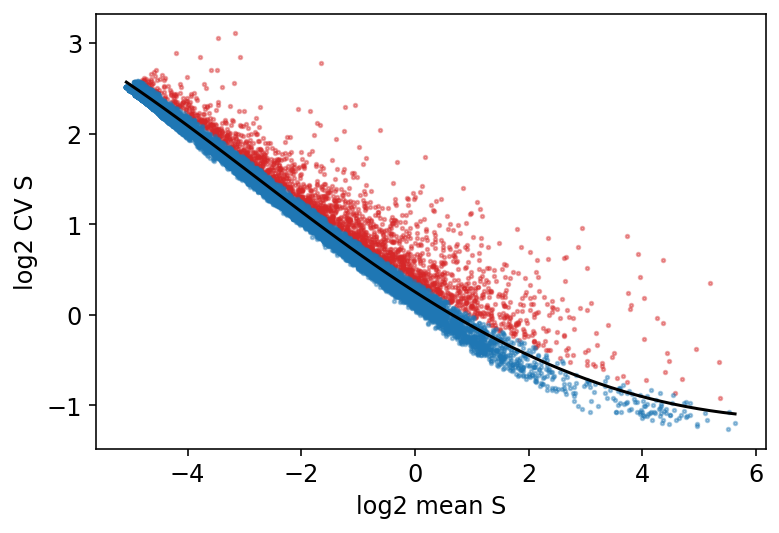

In [54]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [55]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

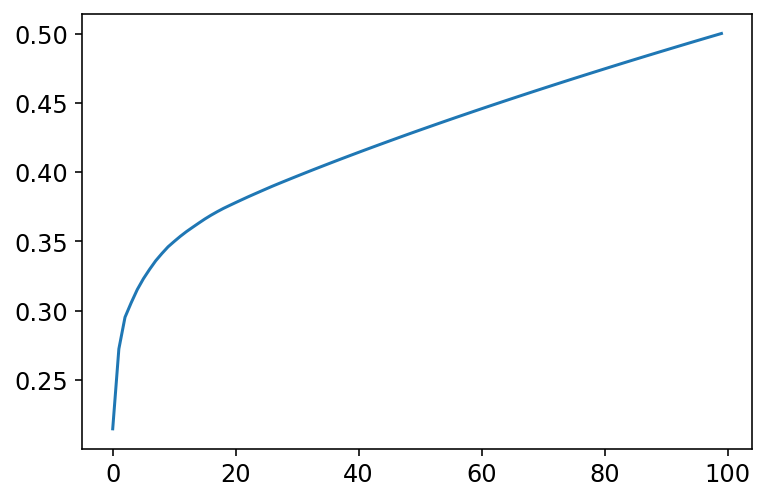

In [56]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [57]:
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [58]:
pc_obj = principal_curve(vlm.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

In [59]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [60]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps, k=k)

In [61]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [62]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [63]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [64]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [65]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

In [66]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

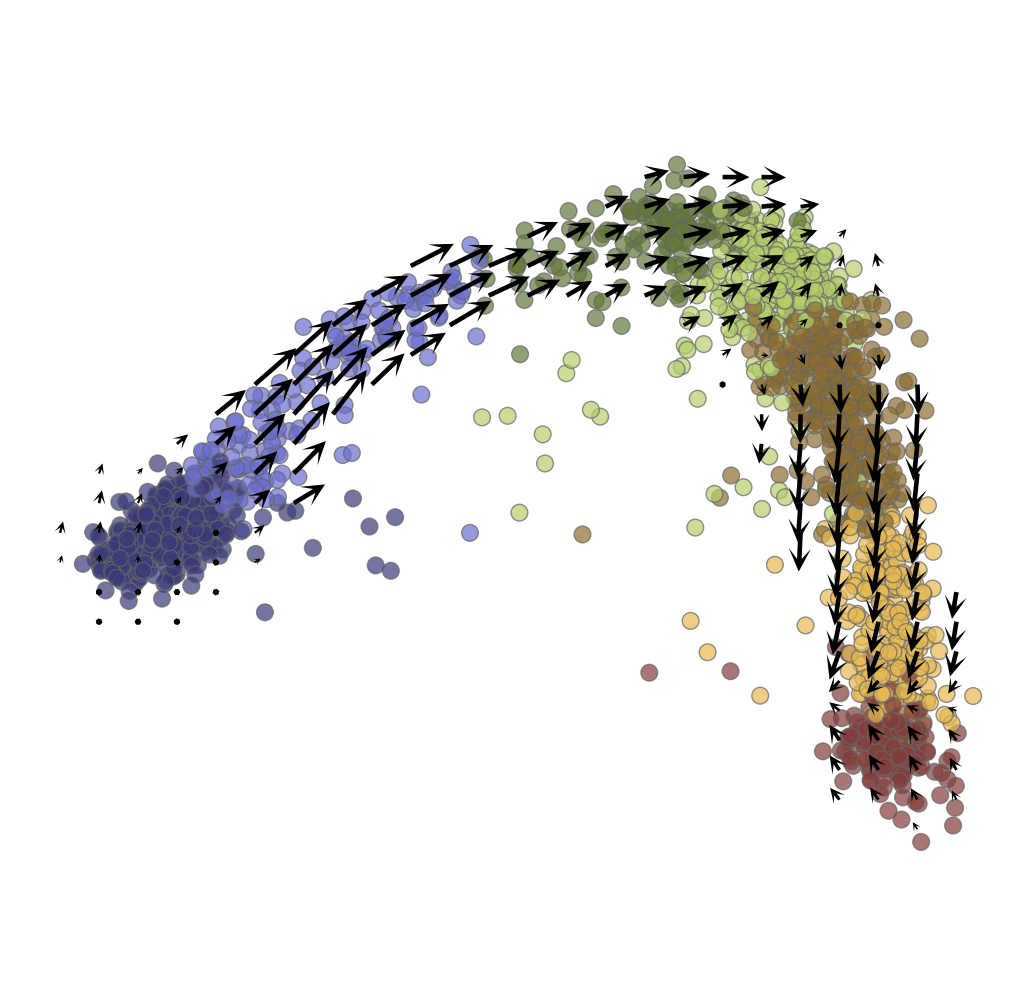

In [67]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
#plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
#plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
#plt.savefig("kallisto_velocity_forebrain_glut.pdf")

In [68]:
! du -hs *

76M	cache
30M	data
43M	final.loom
6.8G	index.idx
55M	sample_data
5.4M	spliced_t2c.txt
1.7G	SRR64070907.tar.gz
15G	SRR6470906
17G	SRR6470907
36M	t2g.txt
16M	unspliced_t2c.txt


In [69]:
! rm -r SRR*

In [70]:
! rm -r data cache index.idx *txt

In [71]:
! rm final.loom